In [1]:
from sklearn.datasets import load_diabetes
import numpy as np

X, y = load_diabetes(return_X_y=True)

# Example with no prior training
We lear all examples one at a time. The p-values are computed, and the ridge paramter is tuned with regular intervals

In [2]:
from CRR import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(autotune=True)

Err = 0

predictions = np.empty((X.shape[0], 6))
for i, (obj, label) in enumerate(zip(X, y)):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma = cp.predict(x, epsilon=0.1, bounds='both')
    width = cp.width(Gamma)
    # Reality presents the label
    cp.learn_one(x, label)  
    err = cp.err(Gamma, label)
    Err += err
    predictions[i, 0] = Gamma[0] # Lower 
    predictions[i, 1] = Gamma[1] # Upper 
    predictions[i, 2] = err # Error
    predictions[i, 3] = label # True label
    predictions[i, 4] = width # True label


/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/CRR.py:299: UserWarning: Significance level epsilon is too small for training set. Need at least 20 examples. Increase or add more examples
  warnings.warn(f'Significance level epsilon is too small for training set. Need at least {int(np.ceil(2/epsilon))} examples. Increase or add more examples')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/CRR.py:472: UserWarning: The matrix X is rank deficient. Condition number: 1.8377100903521824e+17. Consider changing the ridge prarmeter
  warnings.warn(f'The matrix X is rank deficient. Condition number: {np.linalg.cond(M)}. Consider changing the ridge prarmeter')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/CRR.py:472: UserWarning: The matrix X is rank deficient. Condition number: 1.3639496389468293e+18. Consider changing the ridge prarmeter
  warnings.warn(f'The matrix X is rank deficient. Condition number: {np.linalg.cond(M)}. Consider changing the ridge

In [3]:
cp.a

0

In [4]:
Err / X.shape[0]

0.10180995475113122

In [5]:
predictions[100:,4].mean()

206.67876093777937

In [6]:
np.isclose(cp.XTXinv, np.linalg.inv(cp.X.T @ cp.X + cp.a * cp.Id)).all()

False

# Example with initial training set and no successive tuning

In [7]:
from CRR import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(autotune=True)

initial_training_size = 100
X_train = X[:initial_training_size]
y_train = y[:initial_training_size]

X_run = X[initial_training_size:]
y_run = y[initial_training_size:]

cp.learn_initial_training_set(X_train, y_train)

Err = 0

predictions = np.empty((X_run.shape[0], 5))
for i, (obj, label) in enumerate(zip(X_run, y_run)):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma = cp.predict(x, epsilon=0.1, bounds='both')
    width = cp.width(Gamma)
    # Reality presents the label
    cp.learn_one(x, label)  
    err = cp.err(Gamma, label)
    Err += err
    predictions[i, 0] = Gamma[0] # Lower 
    predictions[i, 1] = Gamma[1] # Upper 
    predictions[i, 2] = err # Error
    predictions[i, 3] = label # True label
    predictions[i, 4] = width # True label

In [8]:
cp.a

1.1098525693753387

In [9]:
Err / X[initial_training_size:].shape[0]

0.09064327485380116

In [10]:
predictions[:,4].mean()

204.86341348767908

In [11]:
np.isclose(cp.XTXinv, np.linalg.inv(cp.X.T @ cp.X + cp.a * cp.Id)).all()

True

# Example with test martingale

In [12]:
from CRR import ConformalRidgeRegressor
from martingale import PluginMartingale

X, y = load_diabetes(return_X_y=True)

cp = ConformalRidgeRegressor(autotune=True, a=1)
martingale = PluginMartingale()

martingale_values = []

for i, (obj, label) in enumerate(zip(X, y)):
    # Reality presents the object x
    x = obj
    # Reality presents the label
    p = cp.compute_smoothed_p_value(x, label)
    cp.learn_one(x, label) 
    # Martingale is updated
    martingale.update_log_martingale(p)
    martingale_values.append(martingale.M)

TypeError: bad operand type for unary -: 'list'

In [ ]:
print(f'Exchangeability could be rejected with confidence {1-1/martingale.max}')

Exchangeability could be rejected with confidence 0.02847157353870966


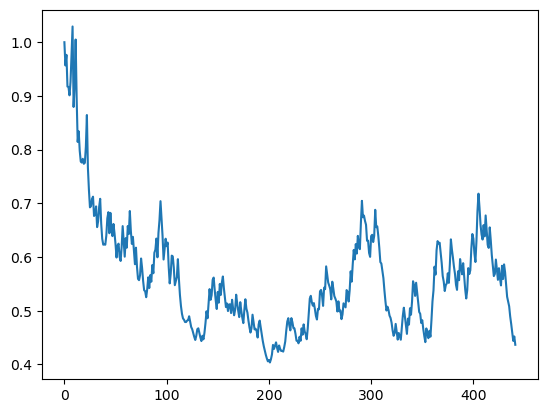

In [ ]:
import matplotlib.pyplot as plt
plt.plot(martingale_values)